In [1]:
from pygris import counties 
import pandas as pd

In [2]:
tx = counties(state = "TX", cb = True, cache = True)

Using the default year of 2021
Using FIPS code '48' for input 'TX'


In [3]:
df = pd.read_excel("pop_reg_growth.xlsx", sheet_name="raw")

In [4]:
tx.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'NAME',
       'NAMELSAD', 'STUSPS', 'STATE_NAME', 'LSAD', 'ALAND', 'AWATER',
       'geometry'],
      dtype='object')

In [5]:
tx["NAME"] = tx["NAME"].str.upper()
tx = tx.merge(df, left_on="NAME", right_on="County Name", how="left")

In [6]:
# Function to classify variable into quantiles (or use a different method like natural breaks)
def classify_variable(series, n_classes):
    return pd.qcut(series, n_classes, labels=False)

tx['var1_class'] = classify_variable(tx['Reg pct change'], 3)  # 3 classes for var1
tx['var2_class'] = classify_variable(tx['Pop pct change'], 3)  # 3 classes for var2


In [7]:
tx[tx['var1_class'].isna()]

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,...,2020 Voter Registration,2024 Voter Registration,Reg change,Reg pct change,Pop 2020,Pop 2023,Pop change,Pop pct change,var1_class,var2_class


In [8]:
import matplotlib.pyplot as plt

# Create a color palette using seaborn's color palettes
# H/T https://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/
cmap = ["#9972af", "#976b82", "#804d36", "#cbb8d7", "#c8ada0", "#af8e53", "#e8e8e8", "#e4d9ac", "#c8b35a"]

# Combine var1_class and var2_class into a single code
tx['bivariate_class'] = tx['var1_class'].astype(str) + "-" + tx['var2_class'].astype(str)

# Create a dictionary mapping class combinations to colors
color_dict = {
    '0-0': cmap[0], '0-1': cmap[1], '0-2': cmap[2],
    '1-0': cmap[3], '1-1': cmap[4], '1-2': cmap[5],
    '2-0': cmap[6], '2-1': cmap[7], '2-2': cmap[8]
}

# Map the bivariate class to color
tx['color'] = tx['bivariate_class'].map(color_dict)


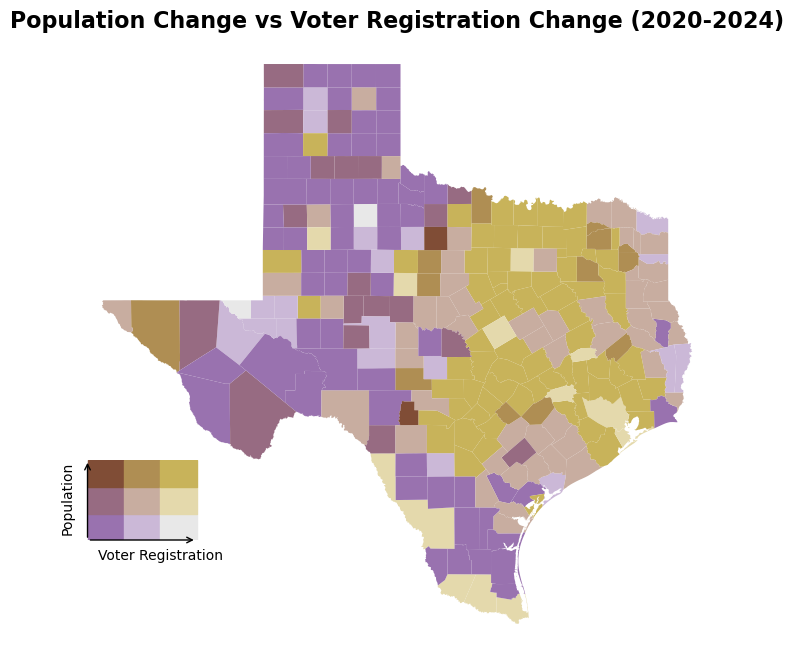

In [10]:
# Plot the bivariate choropleth
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot the map with colors based on the 'color' column
tx.plot(ax=ax, color=tx['color'])

# Optionally remove axis for a cleaner map
ax.set_axis_off()

ax.set_title('Population Change vs Voter Registration Change (2020-2024)', fontsize=16, fontweight='bold')

from matplotlib.patches import Patch

# Create legend patches
legend_labels = {
    '0-0': 'Low-Low', '0-1': 'Low-Mid', '0-2': 'Low-High',
    '1-0': 'Mid-Low', '1-1': 'Mid-Mid', '1-2': 'Mid-High',
    '2-0': 'High-Low', '2-1': 'High-Mid', '2-2': 'High-High'
}

patches = [Patch(facecolor=color_dict[key], label=legend_labels[key]) for key in color_dict]


# H/T https://github.com/mikhailsirenko/bivariate-choropleth

# Add the legend to the plot

# We're drawing a 3x3 "box" as 3 columns
# The xmin and xmax arguments axvspan are defined to create equally sized small boxes

img2 = fig # refer to the main figure
ax2 = fig.add_axes([0.25, 0.25, 0.1, 0.1]) # add new axes to place the legend there
                                         # and specify its location 
alpha = 1 # alpha argument to make it more/less transperent

# Column 1
ax2.axvspan(xmin=0, xmax=0.33, ymin=0, ymax=0.33, alpha=alpha, color=cmap[0])
ax2.axvspan(xmin=0, xmax=0.33, ymin=0.33, ymax=0.66, alpha=alpha, color=cmap[1])
ax2.axvspan(xmin=0, xmax=0.33, ymin=0.66, ymax=1, alpha=alpha, color=cmap[2])

# Column 2
ax2.axvspan(xmin=0.33, xmax=0.66, ymin=0, ymax=0.33, alpha=alpha, color=cmap[3])
ax2.axvspan(xmin=0.33, xmax=0.66, ymin=0.33, ymax=0.66, alpha=alpha, color=cmap[4])
ax2.axvspan(xmin=0.33, xmax=0.66, ymin=0.66, ymax=1, alpha=alpha, color=cmap[5])

# Column 3
ax2.axvspan(xmin=0.66, xmax=1, ymin=0, ymax=0.33, alpha=alpha, color=cmap[6])
ax2.axvspan(xmin=0.66, xmax=1, ymin=0.33, ymax=0.66, alpha=alpha, color=cmap[7])
ax2.axvspan(xmin=0.66, xmax=1, ymin=0.66, ymax=1, alpha=alpha, color=cmap[8])

# Step 3: annoate the legend
ax2.tick_params(axis='both', which='both', length=0) # remove ticks from the big box
ax2.axis('off'); # turn off its axis
ax2.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1)) # draw arrow for x 
ax2.annotate("", xy=(1, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1)) # draw arrow for y 
ax2.text(s='Voter Registration', x=0.1, y=-0.25) # annotate x axis
ax2.text(s='Population', x=-0.25, y=0.1, rotation=90); # annotate y axis
plt.savefig('bivariate_choropleth.png', dpi=300)

plt.show()
